llama_model_loader: loaded meta data with 40 key-value pairs and 197 tensors from /media/hessel/Media/lm-studio/bartowski/Phi-3.5-mini-instruct-GGUF/Phi-3.5-mini-instruct-Q8_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = phi3
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Phi 3.5 Mini Instruct
llama_model_loader: - kv   3:                           general.finetune str              = instruct
llama_model_loader: - kv   4:                           general.basename str              = Phi-3.5
llama_model_loader: - kv   5:                         general.size_label str              = mini
llama_model_loader: - kv   6:                            general.license str           

llama_model_loader: - kv  25:                      tokenizer.ggml.tokens arr[str,32064]   = ["<unk>", "<s>", "</s>", "<0x00>", "<...
llama_model_loader: - kv  26:                      tokenizer.ggml.scores arr[f32,32064]   = [-1000.000000, -1000.000000, -1000.00...
llama_model_loader: - kv  27:                  tokenizer.ggml.token_type arr[i32,32064]   = [3, 3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...
llama_model_loader: - kv  28:                tokenizer.ggml.bos_token_id u32              = 1
llama_model_loader: - kv  29:                tokenizer.ggml.eos_token_id u32              = 32000
llama_model_loader: - kv  30:            tokenizer.ggml.unknown_token_id u32              = 0
llama_model_loader: - kv  31:            tokenizer.ggml.padding_token_id u32              = 32000
llama_model_loader: - kv  32:               tokenizer.ggml.add_bos_token bool             = false
llama_model_loader: - kv  33:               tokenizer.ggml.add_eos_token bool             = false
llama_model_loader: -

{
  "error": "Got invalid JSON object. Error: Expecting property name enclosed in double quotes: line 2 column 30 (char 31)",
  "fraud_risk": "Unknown",
  "reasons": [
    "Error occurred during analysis"
  ],
  "recommended_actions": [
    "Review transaction manually"
  ]
}
{'error': 'Got invalid JSON object. Error: Expecting property name enclosed in '
          'double quotes: line 2 column 30 (char 31)',
 'fraud_risk': 'Unknown',
 'reasons': ['Error occurred during analysis'],
 'recommended_actions': ['Review transaction manually']}


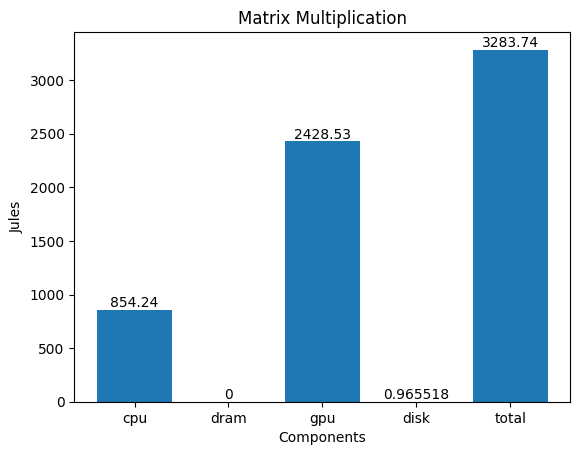

In [3]:
from langchain_community.llms import LlamaCpp
from langchain_core.prompts import PromptTemplate
from langchain.output_parsers import StructuredOutputParser, ResponseSchema
from langchain.chains import LLMChain
from datetime import datetime, date
from decimal import Decimal
import sys
import json
import pprint
sys.path.append("../")
from models.transaction import TransactionModel
from tools.EnergyMeter.energy_meter import EnergyMeter

def detect_fraud(transaction: TransactionModel) -> dict:
    llm = LlamaCpp(
        model_path="/media/hessel/Media/lm-studio/bartowski/Phi-3.5-mini-instruct-GGUF/Phi-3.5-mini-instruct-Q8_0.gguf",
        temperature=0.1,
        max_tokens=2000,
        n_ctx=2048,
        n_batch=512,
        n_gpu_layers=-1,
        f16_kv=True,
        verbose=True,
        use_mlock=False,
        use_mmap=True
    )

    response_schemas = [
        ResponseSchema(name="fraud_risk", description="The level of fraud risk (Low/Medium/High)"),
        ResponseSchema(name="reasons", description="Reasons for the fraud risk assessment"),
        ResponseSchema(name="recommended_actions", description="Recommended actions based on the assessment"),
    ]

    output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

    prompt = PromptTemplate(
        input_variables=["transaction_details"],
        partial_variables={"format_instructions": output_parser.get_format_instructions()},
        template="""
        Analyze the following transaction details and determine if there's a potential for fraud. 
        Consider factors such as transaction amount, location, merchant details, and any unusual patterns.
        
        Transaction Details:
        {transaction_details}
        
        {format_instructions}
        """,
    )

    chain = LLMChain(llm=llm, prompt=prompt)

    transaction_details = f"""
    Transaction Date/Time: {transaction.trans_date_trans_time}
    Amount: ${transaction.amt}
    Merchant: {transaction.merchant}
    Category: {transaction.category}
    Customer Name: {transaction.first} {transaction.last}
    Customer Location: {transaction.city}, {transaction.state}
    Transaction Location: Lat {transaction.lat}, Long {transaction.long}
    Merchant Location: Lat {transaction.merch_lat}, Long {transaction.merch_long}
    """

    try:
        result = chain.run(transaction_details=transaction_details)
        parsed_result = output_parser.parse(result)
        
        # Ensure the parsed result is JSON serializable
        json_result = json.loads(json.dumps(parsed_result))
        return json_result
    except Exception as e:
        # If there's an error, return a JSON object with an error message
        return {
            "error": str(e),
            "fraud_risk": "Unknown",
            "reasons": ["Error occurred during analysis"],
            "recommended_actions": ["Review transaction manually"]
        }

meter = EnergyMeter(disk_avg_speed=1600*1e6, 
                            disk_active_power=6, 
                            disk_idle_power=1.42, 
                            label="Power usage LLM query", include_idle=False)
meter.begin()

# Create a test transaction
test_transaction = TransactionModel(
    trans_date_trans_time=datetime.now(),
    cc_num="4532015112830366",
    merchant="Tech Gadgets Online",
    category="Electronics",
    amt=Decimal("1999.99"),
    first="John",
    last="Doe",
    gender="M",
    street="123 Main St",
    city="New York",
    state="NY",
    zip="10001",
    lat=40.7128,
    long=-74.0060,
    city_pop=8336817,
    job="Software Engineer",
    dob=date(1985, 5, 15),
    trans_num="TR12345678",
    unix_time=int(datetime.now().timestamp()),
    merch_lat=34.0522,
    merch_long=-118.2437,
    is_fraud=False,
)



# Run the fraud detection
result = detect_fraud(test_transaction)
print(json.dumps(result, indent=2))
pprint.pprint(result)

meter.end()
meter.plot_total_jules_per_component()